[View in Colaboratory](https://colab.research.google.com/github/yylonly/GoogleCoLab/blob/master/4_ServeNet_1_BI_LTSM_(Glove200b_trainedEmbeddingLayer).ipynb)

## ServeNet-LTSM (Glove50b-trainedEmbeddingLayer)

In [0]:
!kill -9 -1

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive
import os
os.chdir("/content/drive/Colab Notebooks/")

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [2]:
!ls -l

total 11967
drwxr-xr-x 2 root root    4096 Mar  1 05:18 10.TensorFlow
drwxr-xr-x 2 root root    4096 Mar  1 07:27 14.Residual Networks
drwxr-xr-x 2 root root    4096 Mar  1 16:08 15.CarDetectionwithYOLOv2
drwxr-xr-x 2 root root    4096 Mar  1 16:27 16.Neural Style Transfer
drwxr-xr-x 2 root root    4096 Mar  1 18:00 17.Face Recognition
-rw-r--r-- 1 root root    1191 May  6 10:15 1D-CNN-BI-LTSM-glove50-loss.pdf
-rw-r--r-- 1 root root    1191 May  6 10:15 1DCNN-BI-LTSM-glove50-top5.pdf
drwxr-xr-x 2 root root    4096 Sep 15  2017 1.Python Basics with Numpy
drwxr-xr-x 2 root root    4096 Mar  1 06:26 2.Logistic Regression as a Neural Network
-rw-r--r-- 1 root root  853443 May  7 16:26 4.ServeNet-1-BI-LTSM (Glove200b-trainedEmbeddingLayer).ipynb
-rw-r--r-- 1 root root  739849 May  6 18:17 4.ServeNet-1DCNN-Bi-LTSM (Glove200b-trainedEmbeddingLayer).ipynb
-rw-r--r-- 1 root root  829886 May  7 16:16 4.ServeNet-1-LTSM (Glove200b-trainedEmbeddingLayer).ipynb
-rw-r--r-- 1 root root    1191 May  5 

In [0]:
#import plaidml.keras
#plaidml.keras.install_backend()

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import h5py
import pandas as pd

#from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.models import load_model
from keras import metrics
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.initializers import glorot_uniform
from keras.callbacks import ModelCheckpoint
from keras.layers.wrappers import Bidirectional

np.random.seed(0)
%matplotlib inline

In [5]:
h5f = h5py.File('data/SplittedPaddedIndexedServiceDataset.h5','r') 
X_train = h5f['indexed_padded_Train_X'][:]
Y_train = h5f['Train_Y_one_hot'][:]
X_test = h5f['indexed_padded_Test_X'][:]
Y_test = h5f['Test_Y_one_hot'][:]
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
h5f.close()

(8123, 110) (8123, 50)
(2061, 110) (2061, 50)


In [6]:
X_train[0]

array([192973,  54273, 270501, 294803, 286278, 121851, 360915, 363921,
       270193, 219115, 154323, 278439, 291761, 191811, 191143, 270193,
       133719, 142813, 388756, 306178, 104329, 142808, 374253, 357266,
       286278, 354433,  54718, 345909, 236860, 142838,  90548, 327482,
       357354, 209662, 374253,  43010, 111455,  91182, 156214,  58791,
       270501,  57488,  54718, 149979, 136170, 270927, 294049,  43010,
       332120, 186717,  69725,  57459, 151349,  86371, 191143, 219115,
        57840, 386474,  58997,  89857, 156216, 122453, 374163, 182908,
       199199, 113067, 360915, 111448, 156216, 386474,  58997, 357412,
       182158, 269798, 357266, 286278,  54718, 107110,  88126, 354433,
       151349, 219113, 360915, 191135, 388711, 357266, 325899, 268046,
       325776, 188836, 281890,  61645, 373469, 363840,  54718,  61640,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0], dtype=int32)

In [7]:
Y_train[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [0]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [0]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('data/glove.6B.200d.txt')

In [0]:
# GRADED FUNCTION: pretrained_embedding_layer

def trainable_embedding_layer():
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    ### START CODE HERE ###
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        embedding_vector = word_to_vec_map.get(word)
        if embedding_vector is not None:
            emb_matrix[index, :] = embedding_vector

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)
    ### END CODE HERE ###

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [0]:
# GRADED FUNCTION: Emojify_V2

def ServeNet(input_shape):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    ### START CODE HERE ###
    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices = Input(shape=input_shape, dtype='int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = trainable_embedding_layer()
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices) 
     
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a single hidden state, not a batch of sequences.
    X = Bidirectional(LSTM(256, return_sequences=False))(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
    X = Dense(50)(X)
    # Add a softmax activation
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices, outputs=X)
    
    ### END CODE HERE ###
    
    return model

In [0]:
maxLen = 110

In [13]:
model = ServeNet((maxLen, ))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 110)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 110, 200)          80000200  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               935936    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                25650     
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
Total params: 80,961,786
Trainable params: 961,586
Non-trainable params: 80,000,200
__________________________________________________________

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[metrics.categorical_accuracy, metrics.top_k_categorical_accuracy])

In [15]:
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 100, batch_size = 128)

Train on 8123 samples, validate on 2061 samples
Epoch 1/100
8123/8123 [==============================] - 37s 5ms/step - loss: 3.3920 - categorical_accuracy: 0.1610 - top_k_categorical_accuracy: 0.4067 - val_loss: 2.9103 - val_categorical_accuracy: 0.2780 - val_top_k_categorical_accuracy: 0.5754
Epoch 2/100
8123/8123 [==============================] - 36s 4ms/step - loss: 2.6181 - categorical_accuracy: 0.3244 - top_k_categorical_accuracy: 0.6483 - val_loss: 2.3380 - val_categorical_accuracy: 0.3852 - val_top_k_categorical_accuracy: 0.7162
Epoch 3/100
8123/8123 [==============================] - 37s 4ms/step - loss: 2.1640 - categorical_accuracy: 0.4264 - top_k_categorical_accuracy: 0.7503 - val_loss: 2.0379 - val_categorical_accuracy: 0.4629 - val_top_k_categorical_accuracy: 0.7928
Epoch 4/100
1664/8123 [=====>........................] - ETA: 26s - loss: 1.9040 - categorical_accuracy: 0.5006 - top_k_categorical_accuracy: 0.8035

8123/8123 [==============================] - 37s 5ms/step - loss: 1.8578 - categorical_accuracy: 0.5102 - top_k_categorical_accuracy: 0.8158 - val_loss: 1.8560 - val_categorical_accuracy: 0.5104 - val_top_k_categorical_accuracy: 0.8239
Epoch 5/100
8123/8123 [==============================] - 37s 5ms/step - loss: 1.6607 - categorical_accuracy: 0.5540 - top_k_categorical_accuracy: 0.8478 - val_loss: 1.6745 - val_categorical_accuracy: 0.5594 - val_top_k_categorical_accuracy: 0.8399
Epoch 6/100
8123/8123 [==============================] - 37s 5ms/step - loss: 1.4741 - categorical_accuracy: 0.6019 - top_k_categorical_accuracy: 0.8816 - val_loss: 1.6198 - val_categorical_accuracy: 0.5745 - val_top_k_categorical_accuracy: 0.8520
Epoch 7/100
3712/8123 [============>.................] - ETA: 18s - loss: 1.3264 - categorical_accuracy: 0.6369 - top_k_categorical_accuracy: 0.8963

8123/8123 [==============================] - 37s 5ms/step - loss: 1.3104 - categorical_accuracy: 0.6371 - top_k_categorical_accuracy: 0.9023 - val_loss: 1.5746 - val_categorical_accuracy: 0.5779 - val_top_k_categorical_accuracy: 0.8574
Epoch 8/100
8123/8123 [==============================] - 37s 5ms/step - loss: 1.2266 - categorical_accuracy: 0.6591 - top_k_categorical_accuracy: 0.9091 - val_loss: 1.5240 - val_categorical_accuracy: 0.5973 - val_top_k_categorical_accuracy: 0.8612
Epoch 9/100
8123/8123 [==============================] - 37s 4ms/step - loss: 1.1232 - categorical_accuracy: 0.6866 - top_k_categorical_accuracy: 0.9270 - val_loss: 1.5087 - val_categorical_accuracy: 0.5958 - val_top_k_categorical_accuracy: 0.8627
Epoch 10/100
4096/8123 [==============>...............] - ETA: 16s - loss: 0.9927 - categorical_accuracy: 0.7205 - top_k_categorical_accuracy: 0.9426

8123/8123 [==============================] - 36s 4ms/step - loss: 1.0066 - categorical_accuracy: 0.7166 - top_k_categorical_accuracy: 0.9377 - val_loss: 1.4754 - val_categorical_accuracy: 0.6128 - val_top_k_categorical_accuracy: 0.8714
Epoch 11/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.9131 - categorical_accuracy: 0.7394 - top_k_categorical_accuracy: 0.9494 - val_loss: 1.5106 - val_categorical_accuracy: 0.6206 - val_top_k_categorical_accuracy: 0.8685
Epoch 12/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.8272 - categorical_accuracy: 0.7636 - top_k_categorical_accuracy: 0.9573 - val_loss: 1.5968 - val_categorical_accuracy: 0.6007 - val_top_k_categorical_accuracy: 0.8530
Epoch 13/100
4096/8123 [==============>...............] - ETA: 16s - loss: 0.7324 - categorical_accuracy: 0.7881 - top_k_categorical_accuracy: 0.9683

8123/8123 [==============================] - 36s 4ms/step - loss: 0.7622 - categorical_accuracy: 0.7806 - top_k_categorical_accuracy: 0.9663 - val_loss: 1.5601 - val_categorical_accuracy: 0.6123 - val_top_k_categorical_accuracy: 0.8661
Epoch 14/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.6987 - categorical_accuracy: 0.7975 - top_k_categorical_accuracy: 0.9693 - val_loss: 1.5956 - val_categorical_accuracy: 0.6196 - val_top_k_categorical_accuracy: 0.8617
Epoch 15/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.6155 - categorical_accuracy: 0.8206 - top_k_categorical_accuracy: 0.9753 - val_loss: 1.6146 - val_categorical_accuracy: 0.6070 - val_top_k_categorical_accuracy: 0.8588
Epoch 16/100
4096/8123 [==============>...............] - ETA: 16s - loss: 0.5482 - categorical_accuracy: 0.8445 - top_k_categorical_accuracy: 0.9810

8123/8123 [==============================] - 36s 4ms/step - loss: 0.5740 - categorical_accuracy: 0.8377 - top_k_categorical_accuracy: 0.9787 - val_loss: 1.6716 - val_categorical_accuracy: 0.6046 - val_top_k_categorical_accuracy: 0.8535
Epoch 17/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.5023 - categorical_accuracy: 0.8582 - top_k_categorical_accuracy: 0.9846 - val_loss: 1.6307 - val_categorical_accuracy: 0.6220 - val_top_k_categorical_accuracy: 0.8656
Epoch 18/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.4207 - categorical_accuracy: 0.8806 - top_k_categorical_accuracy: 0.9872 - val_loss: 1.7124 - val_categorical_accuracy: 0.6123 - val_top_k_categorical_accuracy: 0.8598
Epoch 19/100
4096/8123 [==============>...............] - ETA: 16s - loss: 0.3671 - categorical_accuracy: 0.8936 - top_k_categorical_accuracy: 0.9888

8123/8123 [==============================] - 36s 4ms/step - loss: 0.3760 - categorical_accuracy: 0.8917 - top_k_categorical_accuracy: 0.9903 - val_loss: 1.7366 - val_categorical_accuracy: 0.6118 - val_top_k_categorical_accuracy: 0.8632
Epoch 20/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.3726 - categorical_accuracy: 0.8907 - top_k_categorical_accuracy: 0.9930 - val_loss: 1.7453 - val_categorical_accuracy: 0.6046 - val_top_k_categorical_accuracy: 0.8651
Epoch 21/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.3209 - categorical_accuracy: 0.9112 - top_k_categorical_accuracy: 0.9941 - val_loss: 1.8283 - val_categorical_accuracy: 0.6060 - val_top_k_categorical_accuracy: 0.8588
Epoch 22/100
4096/8123 [==============>...............] - ETA: 16s - loss: 0.2984 - categorical_accuracy: 0.9128 - top_k_categorical_accuracy: 0.9954

8123/8123 [==============================] - 36s 4ms/step - loss: 0.2896 - categorical_accuracy: 0.9159 - top_k_categorical_accuracy: 0.9952 - val_loss: 1.7719 - val_categorical_accuracy: 0.6254 - val_top_k_categorical_accuracy: 0.8646
Epoch 23/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.2326 - categorical_accuracy: 0.9378 - top_k_categorical_accuracy: 0.9969 - val_loss: 1.8584 - val_categorical_accuracy: 0.6050 - val_top_k_categorical_accuracy: 0.8578
Epoch 24/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.2300 - categorical_accuracy: 0.9367 - top_k_categorical_accuracy: 0.9980 - val_loss: 1.9605 - val_categorical_accuracy: 0.6060 - val_top_k_categorical_accuracy: 0.8549
Epoch 25/100
4096/8123 [==============>...............] - ETA: 16s - loss: 0.2015 - categorical_accuracy: 0.9443 - top_k_categorical_accuracy: 0.9976

8123/8123 [==============================] - 36s 4ms/step - loss: 0.1956 - categorical_accuracy: 0.9473 - top_k_categorical_accuracy: 0.9980 - val_loss: 1.9058 - val_categorical_accuracy: 0.6152 - val_top_k_categorical_accuracy: 0.8583
Epoch 26/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.1703 - categorical_accuracy: 0.9554 - top_k_categorical_accuracy: 0.9988 - val_loss: 1.9277 - val_categorical_accuracy: 0.6075 - val_top_k_categorical_accuracy: 0.8530
Epoch 27/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.1900 - categorical_accuracy: 0.9487 - top_k_categorical_accuracy: 0.9974 - val_loss: 2.0089 - val_categorical_accuracy: 0.6046 - val_top_k_categorical_accuracy: 0.8540
Epoch 28/100
4096/8123 [==============>...............] - ETA: 16s - loss: 0.1482 - categorical_accuracy: 0.9617 - top_k_categorical_accuracy: 0.9990

8123/8123 [==============================] - 36s 4ms/step - loss: 0.1719 - categorical_accuracy: 0.9533 - top_k_categorical_accuracy: 0.9985 - val_loss: 1.8993 - val_categorical_accuracy: 0.6104 - val_top_k_categorical_accuracy: 0.8520
Epoch 29/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.1659 - categorical_accuracy: 0.9567 - top_k_categorical_accuracy: 0.9986 - val_loss: 2.1019 - val_categorical_accuracy: 0.6002 - val_top_k_categorical_accuracy: 0.8510
Epoch 30/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.1117 - categorical_accuracy: 0.9713 - top_k_categorical_accuracy: 0.9995 - val_loss: 2.0870 - val_categorical_accuracy: 0.6021 - val_top_k_categorical_accuracy: 0.8520
Epoch 31/100
4096/8123 [==============>...............] - ETA: 16s - loss: 0.0988 - categorical_accuracy: 0.9795 - top_k_categorical_accuracy: 0.9998

8123/8123 [==============================] - 36s 4ms/step - loss: 0.0921 - categorical_accuracy: 0.9789 - top_k_categorical_accuracy: 0.9998 - val_loss: 2.1090 - val_categorical_accuracy: 0.5992 - val_top_k_categorical_accuracy: 0.8574
Epoch 32/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.0869 - categorical_accuracy: 0.9797 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.1869 - val_categorical_accuracy: 0.6026 - val_top_k_categorical_accuracy: 0.8559
Epoch 33/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.0851 - categorical_accuracy: 0.9786 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.1715 - val_categorical_accuracy: 0.5987 - val_top_k_categorical_accuracy: 0.8544
Epoch 34/100
4096/8123 [==============>...............] - ETA: 16s - loss: 0.1043 - categorical_accuracy: 0.9758 - top_k_categorical_accuracy: 0.9995

8123/8123 [==============================] - 36s 4ms/step - loss: 0.1053 - categorical_accuracy: 0.9739 - top_k_categorical_accuracy: 0.9996 - val_loss: 2.1376 - val_categorical_accuracy: 0.6152 - val_top_k_categorical_accuracy: 0.8510
Epoch 35/100
8123/8123 [==============================] - 37s 5ms/step - loss: 0.0659 - categorical_accuracy: 0.9855 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.1999 - val_categorical_accuracy: 0.6041 - val_top_k_categorical_accuracy: 0.8607
Epoch 36/100
8123/8123 [==============================] - 37s 4ms/step - loss: 0.0591 - categorical_accuracy: 0.9868 - top_k_categorical_accuracy: 0.9999 - val_loss: 2.1893 - val_categorical_accuracy: 0.6012 - val_top_k_categorical_accuracy: 0.8593
Epoch 37/100
4096/8123 [==============>...............] - ETA: 16s - loss: 0.0533 - categorical_accuracy: 0.9890 - top_k_categorical_accuracy: 1.0000

8123/8123 [==============================] - 36s 4ms/step - loss: 0.0537 - categorical_accuracy: 0.9886 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.3590 - val_categorical_accuracy: 0.6002 - val_top_k_categorical_accuracy: 0.8443
Epoch 38/100
8123/8123 [==============================] - 37s 4ms/step - loss: 0.1093 - categorical_accuracy: 0.9725 - top_k_categorical_accuracy: 0.9993 - val_loss: 2.1635 - val_categorical_accuracy: 0.6021 - val_top_k_categorical_accuracy: 0.8544
Epoch 39/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.0900 - categorical_accuracy: 0.9792 - top_k_categorical_accuracy: 0.9996 - val_loss: 2.2047 - val_categorical_accuracy: 0.6118 - val_top_k_categorical_accuracy: 0.8588
Epoch 40/100
4096/8123 [==============>...............] - ETA: 16s - loss: 0.0791 - categorical_accuracy: 0.9800 - top_k_categorical_accuracy: 0.9998

8123/8123 [==============================] - 37s 5ms/step - loss: 0.0818 - categorical_accuracy: 0.9792 - top_k_categorical_accuracy: 0.9998 - val_loss: 2.2395 - val_categorical_accuracy: 0.5919 - val_top_k_categorical_accuracy: 0.8467
Epoch 41/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.1132 - categorical_accuracy: 0.9676 - top_k_categorical_accuracy: 0.9995 - val_loss: 2.2595 - val_categorical_accuracy: 0.6021 - val_top_k_categorical_accuracy: 0.8540
Epoch 42/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.1045 - categorical_accuracy: 0.9733 - top_k_categorical_accuracy: 0.9996 - val_loss: 2.1839 - val_categorical_accuracy: 0.6099 - val_top_k_categorical_accuracy: 0.8612
Epoch 43/100
4096/8123 [==============>...............] - ETA: 16s - loss: 0.0799 - categorical_accuracy: 0.9797 - top_k_categorical_accuracy: 0.9998

8123/8123 [==============================] - 36s 4ms/step - loss: 0.0771 - categorical_accuracy: 0.9802 - top_k_categorical_accuracy: 0.9999 - val_loss: 2.2953 - val_categorical_accuracy: 0.6021 - val_top_k_categorical_accuracy: 0.8491
Epoch 44/100
8123/8123 [==============================] - 37s 4ms/step - loss: 0.0843 - categorical_accuracy: 0.9786 - top_k_categorical_accuracy: 0.9998 - val_loss: 2.1706 - val_categorical_accuracy: 0.6249 - val_top_k_categorical_accuracy: 0.8641
Epoch 45/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.0554 - categorical_accuracy: 0.9872 - top_k_categorical_accuracy: 0.9998 - val_loss: 2.2454 - val_categorical_accuracy: 0.6143 - val_top_k_categorical_accuracy: 0.8501
Epoch 46/100
4096/8123 [==============>...............] - ETA: 16s - loss: 0.0376 - categorical_accuracy: 0.9919 - top_k_categorical_accuracy: 1.0000

8123/8123 [==============================] - 37s 5ms/step - loss: 0.0380 - categorical_accuracy: 0.9931 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.3601 - val_categorical_accuracy: 0.6152 - val_top_k_categorical_accuracy: 0.8535
Epoch 47/100
8123/8123 [==============================] - 37s 4ms/step - loss: 0.0302 - categorical_accuracy: 0.9936 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.3542 - val_categorical_accuracy: 0.6114 - val_top_k_categorical_accuracy: 0.8549
Epoch 48/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.0379 - categorical_accuracy: 0.9913 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.3594 - val_categorical_accuracy: 0.6075 - val_top_k_categorical_accuracy: 0.8540
Epoch 49/100
4096/8123 [==============>...............] - ETA: 16s - loss: 0.0504 - categorical_accuracy: 0.9871 - top_k_categorical_accuracy: 1.0000

8123/8123 [==============================] - 36s 4ms/step - loss: 0.0489 - categorical_accuracy: 0.9878 - top_k_categorical_accuracy: 0.9999 - val_loss: 2.3479 - val_categorical_accuracy: 0.6084 - val_top_k_categorical_accuracy: 0.8540
Epoch 50/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.0356 - categorical_accuracy: 0.9931 - top_k_categorical_accuracy: 0.9998 - val_loss: 2.4037 - val_categorical_accuracy: 0.6133 - val_top_k_categorical_accuracy: 0.8535
Epoch 51/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.0195 - categorical_accuracy: 0.9968 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.4308 - val_categorical_accuracy: 0.6167 - val_top_k_categorical_accuracy: 0.8569
Epoch 52/100
4096/8123 [==============>...............] - ETA: 16s - loss: 0.0193 - categorical_accuracy: 0.9973 - top_k_categorical_accuracy: 1.0000

8123/8123 [==============================] - 36s 4ms/step - loss: 0.0180 - categorical_accuracy: 0.9973 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.4355 - val_categorical_accuracy: 0.6109 - val_top_k_categorical_accuracy: 0.8549
Epoch 53/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.0174 - categorical_accuracy: 0.9967 - top_k_categorical_accuracy: 0.9999 - val_loss: 2.4810 - val_categorical_accuracy: 0.6143 - val_top_k_categorical_accuracy: 0.8476
Epoch 54/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.0521 - categorical_accuracy: 0.9866 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.4667 - val_categorical_accuracy: 0.6007 - val_top_k_categorical_accuracy: 0.8481
Epoch 55/100
4096/8123 [==============>...............] - ETA: 16s - loss: 0.0492 - categorical_accuracy: 0.9883 - top_k_categorical_accuracy: 0.9998

8123/8123 [==============================] - 36s 4ms/step - loss: 0.0506 - categorical_accuracy: 0.9883 - top_k_categorical_accuracy: 0.9996 - val_loss: 2.4202 - val_categorical_accuracy: 0.6075 - val_top_k_categorical_accuracy: 0.8462
Epoch 56/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.0316 - categorical_accuracy: 0.9924 - top_k_categorical_accuracy: 0.9999 - val_loss: 2.4188 - val_categorical_accuracy: 0.6070 - val_top_k_categorical_accuracy: 0.8583
Epoch 57/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.0263 - categorical_accuracy: 0.9947 - top_k_categorical_accuracy: 0.9999 - val_loss: 2.4675 - val_categorical_accuracy: 0.6050 - val_top_k_categorical_accuracy: 0.8515
Epoch 58/100
4096/8123 [==============>...............] - ETA: 16s - loss: 0.0456 - categorical_accuracy: 0.9878 - top_k_categorical_accuracy: 1.0000

8123/8123 [==============================] - 36s 4ms/step - loss: 0.0556 - categorical_accuracy: 0.9849 - top_k_categorical_accuracy: 0.9999 - val_loss: 2.4703 - val_categorical_accuracy: 0.6041 - val_top_k_categorical_accuracy: 0.8540
Epoch 59/100
8123/8123 [==============================] - 35s 4ms/step - loss: 0.0505 - categorical_accuracy: 0.9870 - top_k_categorical_accuracy: 0.9996 - val_loss: 2.4771 - val_categorical_accuracy: 0.6099 - val_top_k_categorical_accuracy: 0.8501
Epoch 60/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.0623 - categorical_accuracy: 0.9825 - top_k_categorical_accuracy: 0.9999 - val_loss: 2.3565 - val_categorical_accuracy: 0.6041 - val_top_k_categorical_accuracy: 0.8355
Epoch 61/100
4096/8123 [==============>...............] - ETA: 16s - loss: 0.0576 - categorical_accuracy: 0.9858 - top_k_categorical_accuracy: 1.0000

8123/8123 [==============================] - 36s 4ms/step - loss: 0.0612 - categorical_accuracy: 0.9841 - top_k_categorical_accuracy: 0.9999 - val_loss: 2.5426 - val_categorical_accuracy: 0.6021 - val_top_k_categorical_accuracy: 0.8544
Epoch 62/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.0503 - categorical_accuracy: 0.9874 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.5003 - val_categorical_accuracy: 0.6041 - val_top_k_categorical_accuracy: 0.8544
Epoch 63/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.0409 - categorical_accuracy: 0.9897 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.6035 - val_categorical_accuracy: 0.5958 - val_top_k_categorical_accuracy: 0.8472
Epoch 64/100
4096/8123 [==============>...............] - ETA: 16s - loss: 0.0473 - categorical_accuracy: 0.9888 - top_k_categorical_accuracy: 0.9998

8123/8123 [==============================] - 36s 4ms/step - loss: 0.0490 - categorical_accuracy: 0.9884 - top_k_categorical_accuracy: 0.9996 - val_loss: 2.5839 - val_categorical_accuracy: 0.6016 - val_top_k_categorical_accuracy: 0.8510
Epoch 65/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.0397 - categorical_accuracy: 0.9913 - top_k_categorical_accuracy: 0.9999 - val_loss: 2.4535 - val_categorical_accuracy: 0.6186 - val_top_k_categorical_accuracy: 0.8520
Epoch 66/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.0286 - categorical_accuracy: 0.9937 - top_k_categorical_accuracy: 0.9999 - val_loss: 2.5135 - val_categorical_accuracy: 0.6080 - val_top_k_categorical_accuracy: 0.8515
Epoch 67/100
4096/8123 [==============>...............] - ETA: 16s - loss: 0.0154 - categorical_accuracy: 0.9971 - top_k_categorical_accuracy: 1.0000

8123/8123 [==============================] - 36s 4ms/step - loss: 0.0161 - categorical_accuracy: 0.9968 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.5599 - val_categorical_accuracy: 0.6143 - val_top_k_categorical_accuracy: 0.8564
Epoch 68/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.0279 - categorical_accuracy: 0.9945 - top_k_categorical_accuracy: 0.9999 - val_loss: 2.5304 - val_categorical_accuracy: 0.6109 - val_top_k_categorical_accuracy: 0.8515
Epoch 69/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.0234 - categorical_accuracy: 0.9942 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.5848 - val_categorical_accuracy: 0.6138 - val_top_k_categorical_accuracy: 0.8583
Epoch 70/100
4096/8123 [==============>...............] - ETA: 16s - loss: 0.0137 - categorical_accuracy: 0.9980 - top_k_categorical_accuracy: 1.0000

8123/8123 [==============================] - 36s 4ms/step - loss: 0.0144 - categorical_accuracy: 0.9977 - top_k_categorical_accuracy: 0.9999 - val_loss: 2.6116 - val_categorical_accuracy: 0.6123 - val_top_k_categorical_accuracy: 0.8481
Epoch 71/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.0150 - categorical_accuracy: 0.9974 - top_k_categorical_accuracy: 0.9998 - val_loss: 2.6915 - val_categorical_accuracy: 0.6021 - val_top_k_categorical_accuracy: 0.8476
Epoch 72/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.0158 - categorical_accuracy: 0.9968 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.6636 - val_categorical_accuracy: 0.6099 - val_top_k_categorical_accuracy: 0.8428
Epoch 73/100
4096/8123 [==============>...............] - ETA: 16s - loss: 0.0387 - categorical_accuracy: 0.9900 - top_k_categorical_accuracy: 0.9995

8123/8123 [==============================] - 36s 4ms/step - loss: 0.0456 - categorical_accuracy: 0.9867 - top_k_categorical_accuracy: 0.9996 - val_loss: 2.7328 - val_categorical_accuracy: 0.6031 - val_top_k_categorical_accuracy: 0.8510
Epoch 74/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.0662 - categorical_accuracy: 0.9813 - top_k_categorical_accuracy: 0.9996 - val_loss: 2.5362 - val_categorical_accuracy: 0.6036 - val_top_k_categorical_accuracy: 0.8379
Epoch 75/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.0655 - categorical_accuracy: 0.9830 - top_k_categorical_accuracy: 0.9993 - val_loss: 2.4579 - val_categorical_accuracy: 0.6109 - val_top_k_categorical_accuracy: 0.8544
Epoch 76/100
4096/8123 [==============>...............] - ETA: 16s - loss: 0.0418 - categorical_accuracy: 0.9897 - top_k_categorical_accuracy: 1.0000

8123/8123 [==============================] - 36s 4ms/step - loss: 0.0423 - categorical_accuracy: 0.9894 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.4524 - val_categorical_accuracy: 0.6240 - val_top_k_categorical_accuracy: 0.8554
Epoch 77/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.0244 - categorical_accuracy: 0.9942 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.5158 - val_categorical_accuracy: 0.6070 - val_top_k_categorical_accuracy: 0.8540
Epoch 78/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.0357 - categorical_accuracy: 0.9913 - top_k_categorical_accuracy: 0.9998 - val_loss: 2.5189 - val_categorical_accuracy: 0.6109 - val_top_k_categorical_accuracy: 0.8530
Epoch 79/100
4096/8123 [==============>...............] - ETA: 16s - loss: 0.0400 - categorical_accuracy: 0.9902 - top_k_categorical_accuracy: 0.9995

8123/8123 [==============================] - 36s 4ms/step - loss: 0.0334 - categorical_accuracy: 0.9915 - top_k_categorical_accuracy: 0.9998 - val_loss: 2.6224 - val_categorical_accuracy: 0.6060 - val_top_k_categorical_accuracy: 0.8583
Epoch 80/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.0368 - categorical_accuracy: 0.9904 - top_k_categorical_accuracy: 0.9999 - val_loss: 2.6032 - val_categorical_accuracy: 0.6050 - val_top_k_categorical_accuracy: 0.8540
Epoch 81/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.0532 - categorical_accuracy: 0.9855 - top_k_categorical_accuracy: 0.9996 - val_loss: 2.5789 - val_categorical_accuracy: 0.6099 - val_top_k_categorical_accuracy: 0.8544
Epoch 82/100
4096/8123 [==============>...............] - ETA: 16s - loss: 0.0387 - categorical_accuracy: 0.9902 - top_k_categorical_accuracy: 0.9998

8123/8123 [==============================] - 36s 4ms/step - loss: 0.0457 - categorical_accuracy: 0.9884 - top_k_categorical_accuracy: 0.9998 - val_loss: 2.5392 - val_categorical_accuracy: 0.6089 - val_top_k_categorical_accuracy: 0.8540
Epoch 83/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.0224 - categorical_accuracy: 0.9951 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.5976 - val_categorical_accuracy: 0.6220 - val_top_k_categorical_accuracy: 0.8607
Epoch 84/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.0252 - categorical_accuracy: 0.9936 - top_k_categorical_accuracy: 0.9999 - val_loss: 2.5587 - val_categorical_accuracy: 0.6036 - val_top_k_categorical_accuracy: 0.8544
Epoch 85/100
4096/8123 [==============>...............] - ETA: 16s - loss: 0.0285 - categorical_accuracy: 0.9932 - top_k_categorical_accuracy: 1.0000

8123/8123 [==============================] - 36s 4ms/step - loss: 0.0288 - categorical_accuracy: 0.9926 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.5218 - val_categorical_accuracy: 0.6094 - val_top_k_categorical_accuracy: 0.8637
Epoch 86/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.0185 - categorical_accuracy: 0.9959 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.6013 - val_categorical_accuracy: 0.6133 - val_top_k_categorical_accuracy: 0.8607
Epoch 87/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.0089 - categorical_accuracy: 0.9989 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.6490 - val_categorical_accuracy: 0.6230 - val_top_k_categorical_accuracy: 0.8510
Epoch 88/100
4096/8123 [==============>...............] - ETA: 16s - loss: 0.0069 - categorical_accuracy: 0.9990 - top_k_categorical_accuracy: 1.0000

8123/8123 [==============================] - 36s 4ms/step - loss: 0.0056 - categorical_accuracy: 0.9994 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.7013 - val_categorical_accuracy: 0.6254 - val_top_k_categorical_accuracy: 0.8564
Epoch 89/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.0044 - categorical_accuracy: 0.9994 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.7434 - val_categorical_accuracy: 0.6196 - val_top_k_categorical_accuracy: 0.8544
Epoch 90/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.0043 - categorical_accuracy: 0.9994 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.8147 - val_categorical_accuracy: 0.6181 - val_top_k_categorical_accuracy: 0.8520
Epoch 91/100
4096/8123 [==============>...............] - ETA: 16s - loss: 0.0182 - categorical_accuracy: 0.9951 - top_k_categorical_accuracy: 0.9998

8123/8123 [==============================] - 36s 4ms/step - loss: 0.0175 - categorical_accuracy: 0.9962 - top_k_categorical_accuracy: 0.9998 - val_loss: 2.6935 - val_categorical_accuracy: 0.6080 - val_top_k_categorical_accuracy: 0.8530
Epoch 92/100
8123/8123 [==============================] - 37s 5ms/step - loss: 0.0125 - categorical_accuracy: 0.9975 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.7140 - val_categorical_accuracy: 0.6211 - val_top_k_categorical_accuracy: 0.8491
Epoch 93/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.0239 - categorical_accuracy: 0.9935 - top_k_categorical_accuracy: 0.9999 - val_loss: 2.7208 - val_categorical_accuracy: 0.6148 - val_top_k_categorical_accuracy: 0.8501
Epoch 94/100
4096/8123 [==============>...............] - ETA: 16s - loss: 0.0340 - categorical_accuracy: 0.9907 - top_k_categorical_accuracy: 1.0000

8123/8123 [==============================] - 36s 4ms/step - loss: 0.0523 - categorical_accuracy: 0.9867 - top_k_categorical_accuracy: 0.9999 - val_loss: 2.6217 - val_categorical_accuracy: 0.6157 - val_top_k_categorical_accuracy: 0.8486
Epoch 95/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.0719 - categorical_accuracy: 0.9805 - top_k_categorical_accuracy: 0.9991 - val_loss: 2.4326 - val_categorical_accuracy: 0.6148 - val_top_k_categorical_accuracy: 0.8535
Epoch 96/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.1148 - categorical_accuracy: 0.9675 - top_k_categorical_accuracy: 0.9985 - val_loss: 2.4659 - val_categorical_accuracy: 0.5978 - val_top_k_categorical_accuracy: 0.8462
Epoch 97/100
4096/8123 [==============>...............] - ETA: 16s - loss: 0.0894 - categorical_accuracy: 0.9766 - top_k_categorical_accuracy: 0.9995

8123/8123 [==============================] - 36s 4ms/step - loss: 0.0705 - categorical_accuracy: 0.9810 - top_k_categorical_accuracy: 0.9996 - val_loss: 2.5225 - val_categorical_accuracy: 0.6104 - val_top_k_categorical_accuracy: 0.8578
Epoch 98/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.0370 - categorical_accuracy: 0.9910 - top_k_categorical_accuracy: 0.9999 - val_loss: 2.5225 - val_categorical_accuracy: 0.6201 - val_top_k_categorical_accuracy: 0.8603
Epoch 99/100
8123/8123 [==============================] - 36s 4ms/step - loss: 0.0310 - categorical_accuracy: 0.9926 - top_k_categorical_accuracy: 0.9999 - val_loss: 2.5819 - val_categorical_accuracy: 0.6283 - val_top_k_categorical_accuracy: 0.8578
Epoch 100/100
4096/8123 [==============>...............] - ETA: 16s - loss: 0.0128 - categorical_accuracy: 0.9978 - top_k_categorical_accuracy: 1.0000

8123/8123 [==============================] - 36s 4ms/step - loss: 0.0136 - categorical_accuracy: 0.9973 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.6133 - val_categorical_accuracy: 0.6245 - val_top_k_categorical_accuracy: 0.8554


In [16]:
!ls -l

total 11948
drwxr-xr-x 2 root root    4096 Mar  1 05:18 10.TensorFlow
drwxr-xr-x 2 root root    4096 Mar  1 07:27 14.Residual Networks
drwxr-xr-x 2 root root    4096 Mar  1 16:08 15.CarDetectionwithYOLOv2
drwxr-xr-x 2 root root    4096 Mar  1 16:27 16.Neural Style Transfer
drwxr-xr-x 2 root root    4096 Mar  1 18:00 17.Face Recognition
-rw-r--r-- 1 root root    1191 May  6 10:15 1D-CNN-BI-LTSM-glove50-loss.pdf
-rw-r--r-- 1 root root    1191 May  6 10:15 1DCNN-BI-LTSM-glove50-top5.pdf
drwxr-xr-x 2 root root    4096 Sep 15  2017 1.Python Basics with Numpy
drwxr-xr-x 2 root root    4096 Mar  1 06:26 2.Logistic Regression as a Neural Network
-rw-r--r-- 1 root root  833635 May  7 17:29 4.ServeNet-1-BI-LTSM (Glove200b-trainedEmbeddingLayer).ipynb
-rw-r--r-- 1 root root  739849 May  6 18:17 4.ServeNet-1DCNN-Bi-LTSM (Glove200b-trainedEmbeddingLayer).ipynb
-rw-r--r-- 1 root root  829886 May  7 16:16 4.ServeNet-1-LTSM (Glove200b-trainedEmbeddingLayer).ipynb
-rw-r--r-- 1 root root    1191 May  5 

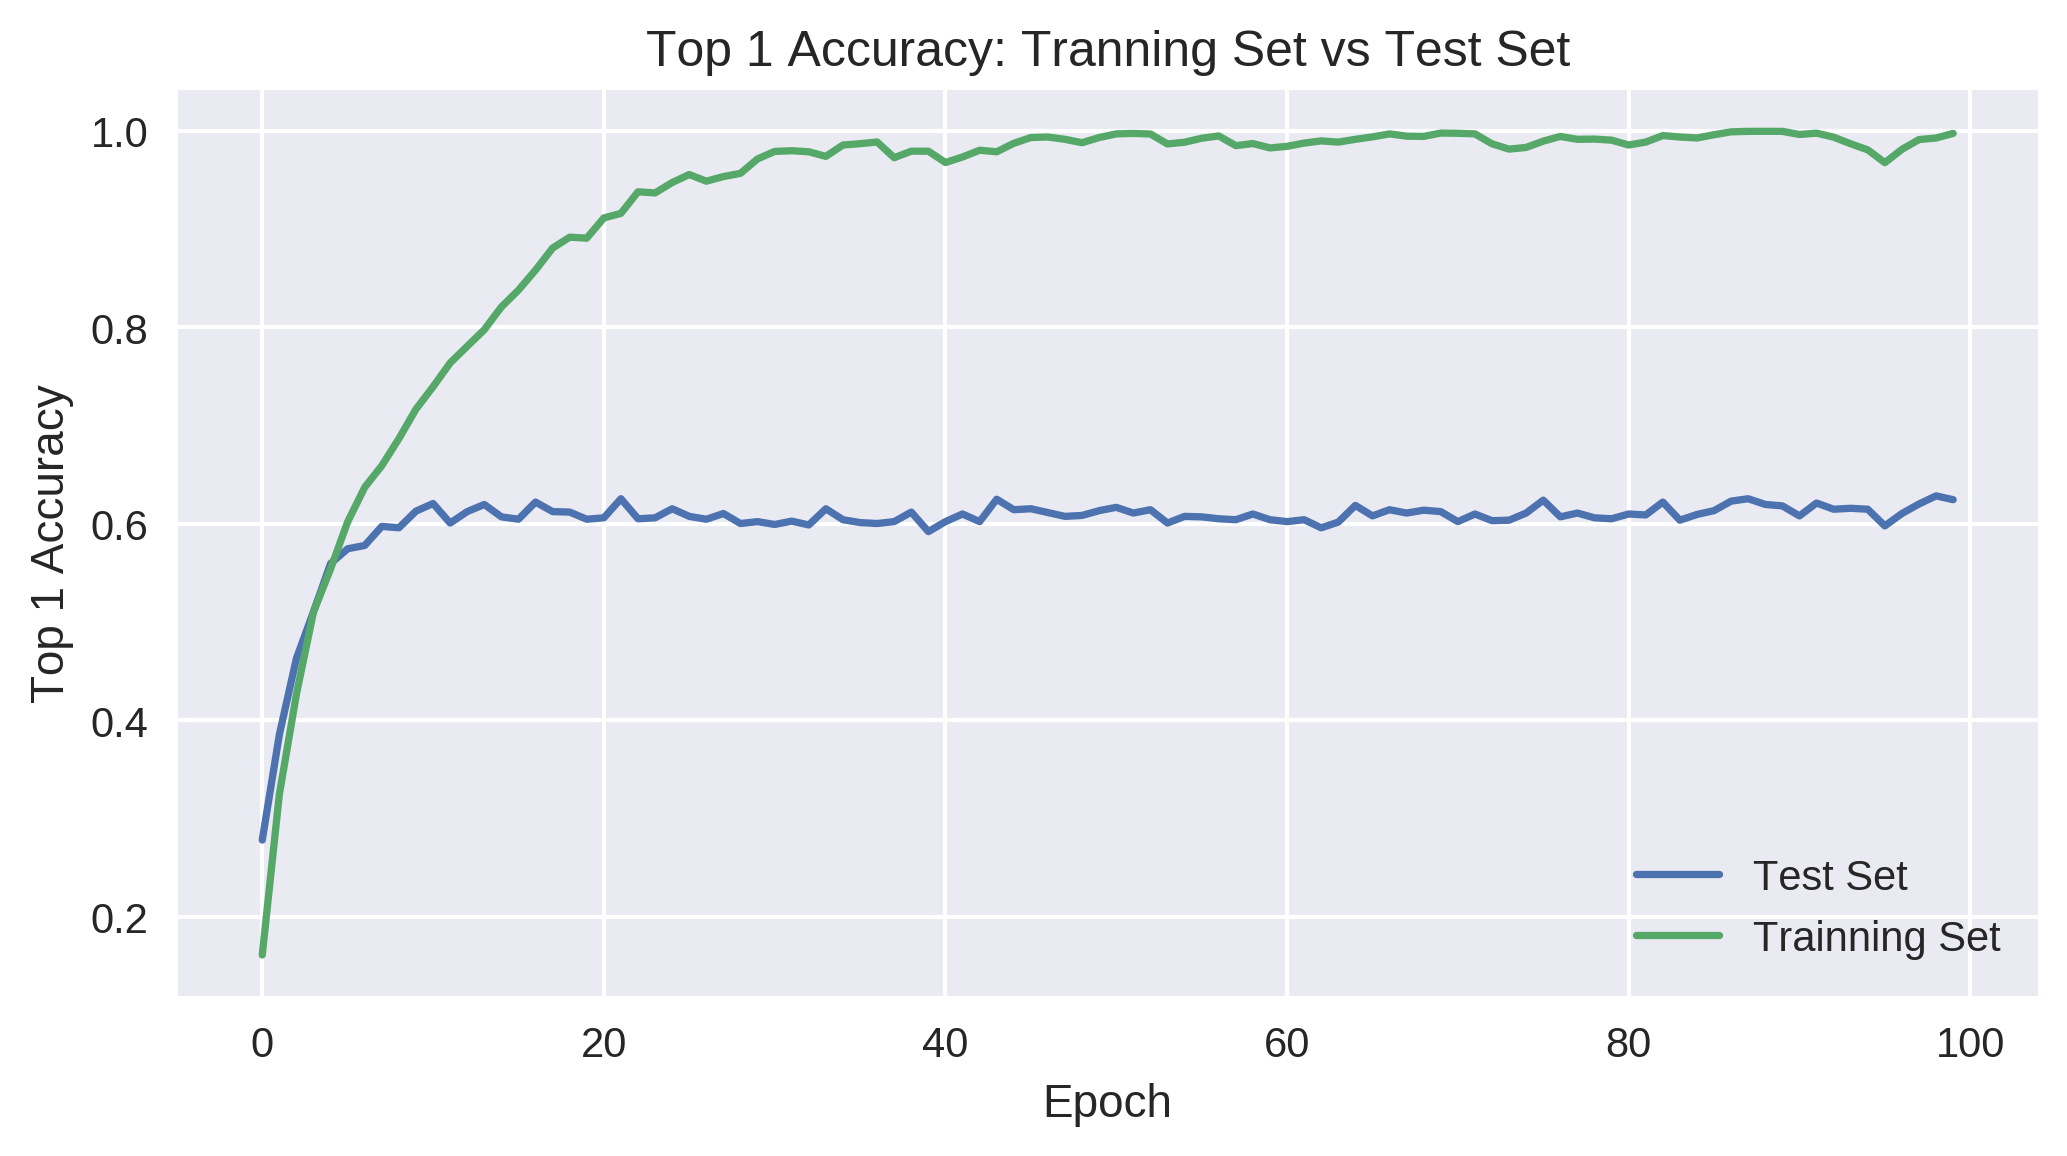

In [17]:
# plot metrics
plt.figure(figsize=(8, 4), dpi=300)
plt.title("Top 1 Accuracy: Tranning Set vs Test Set")
plt.xlabel("Epoch")
plt.ylabel("Top 1 Accuracy")
plt.plot(history.history['val_categorical_accuracy'], label="Test Set")
plt.plot(history.history['categorical_accuracy'], label="Trainning Set")
plt.legend()
plt.show()

### Plot Loss

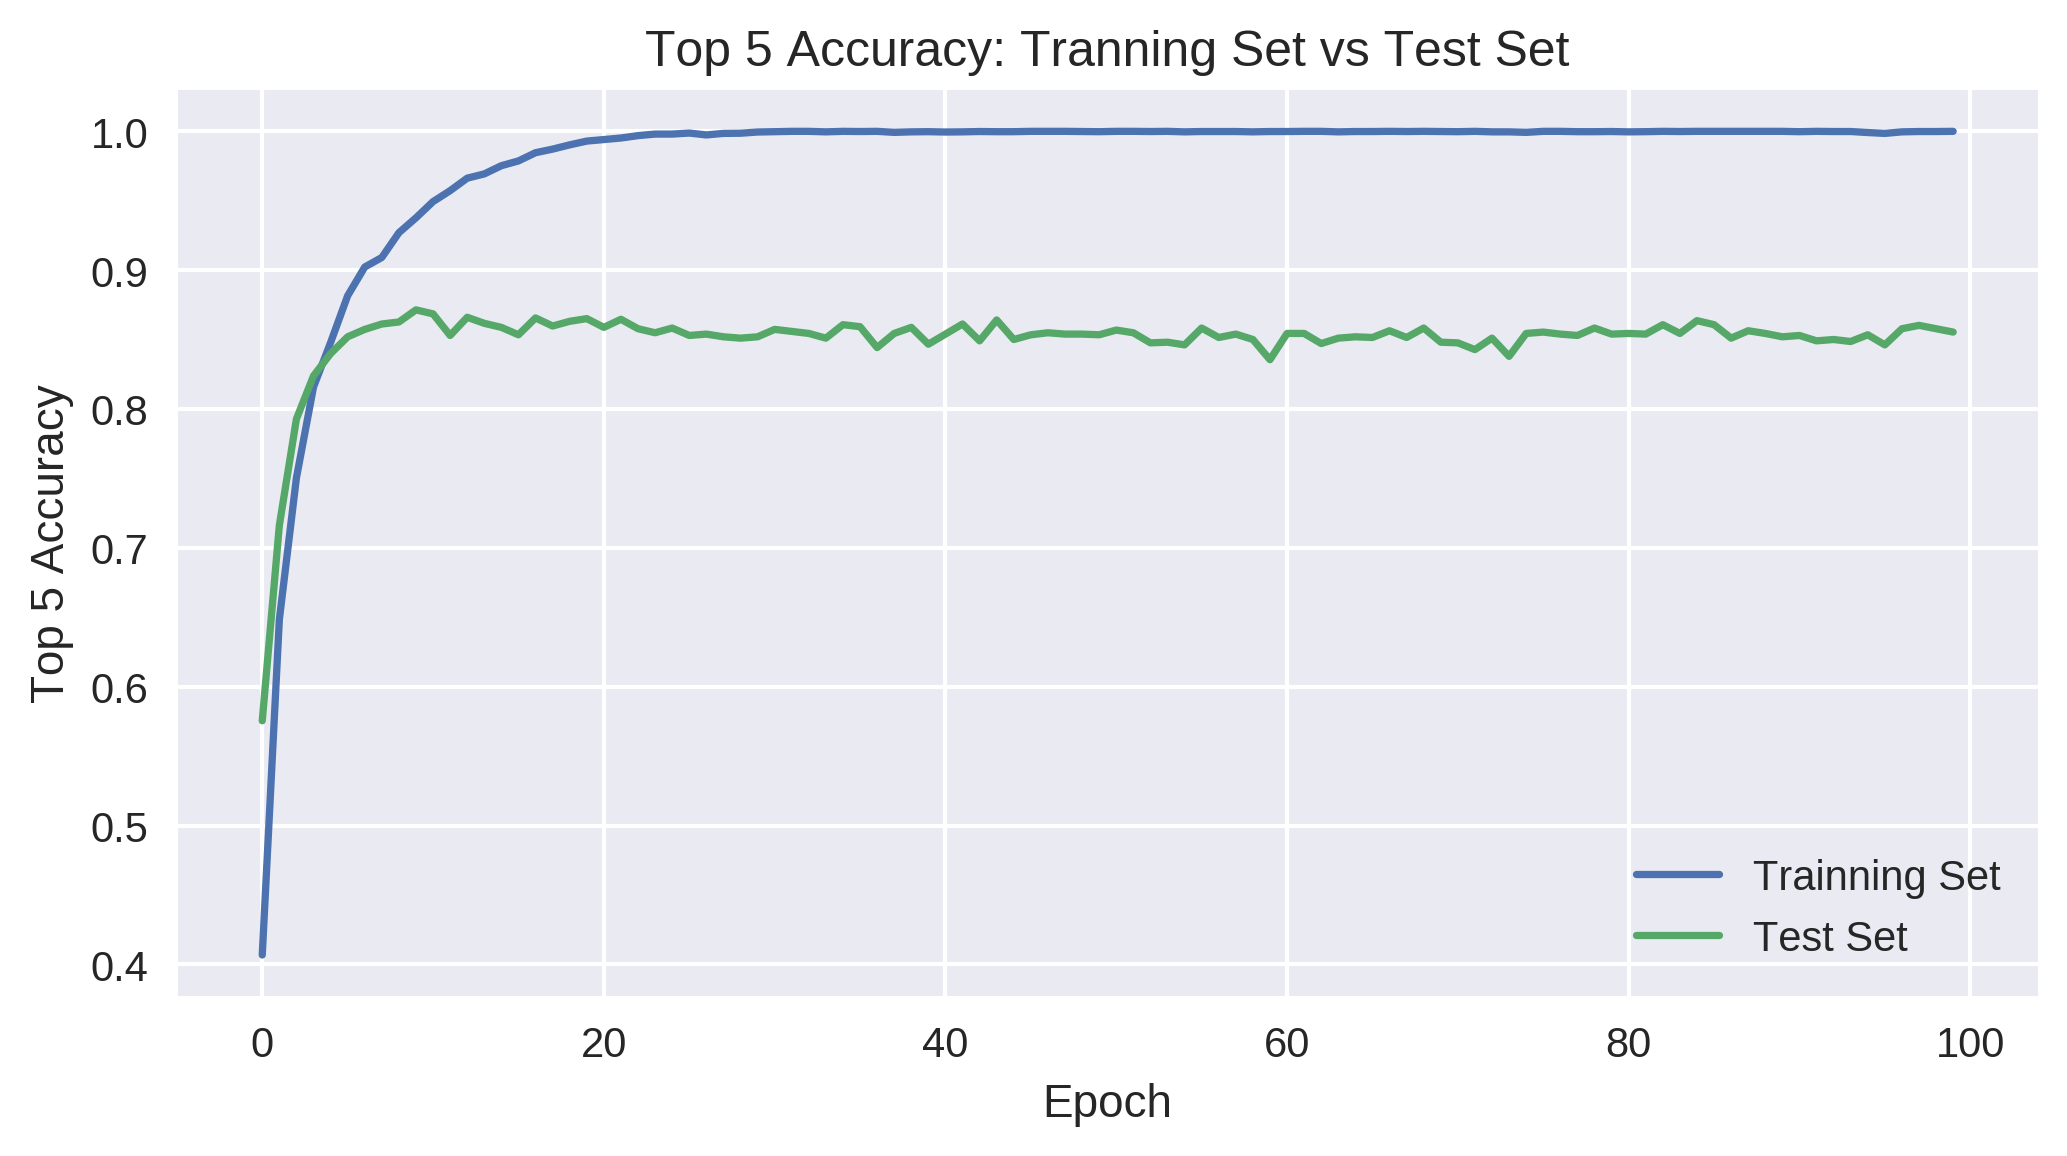

In [18]:
# plot metrics
plt.figure(figsize=(8, 4), dpi=300)
plt.title("Top 5 Accuracy: Tranning Set vs Test Set")
plt.xlabel("Epoch")
plt.ylabel("Top 5 Accuracy")
plt.plot(history.history['top_k_categorical_accuracy'], label="Trainning Set")
plt.plot(history.history['val_top_k_categorical_accuracy'], label="Test Set")
plt.legend()
plt.show()

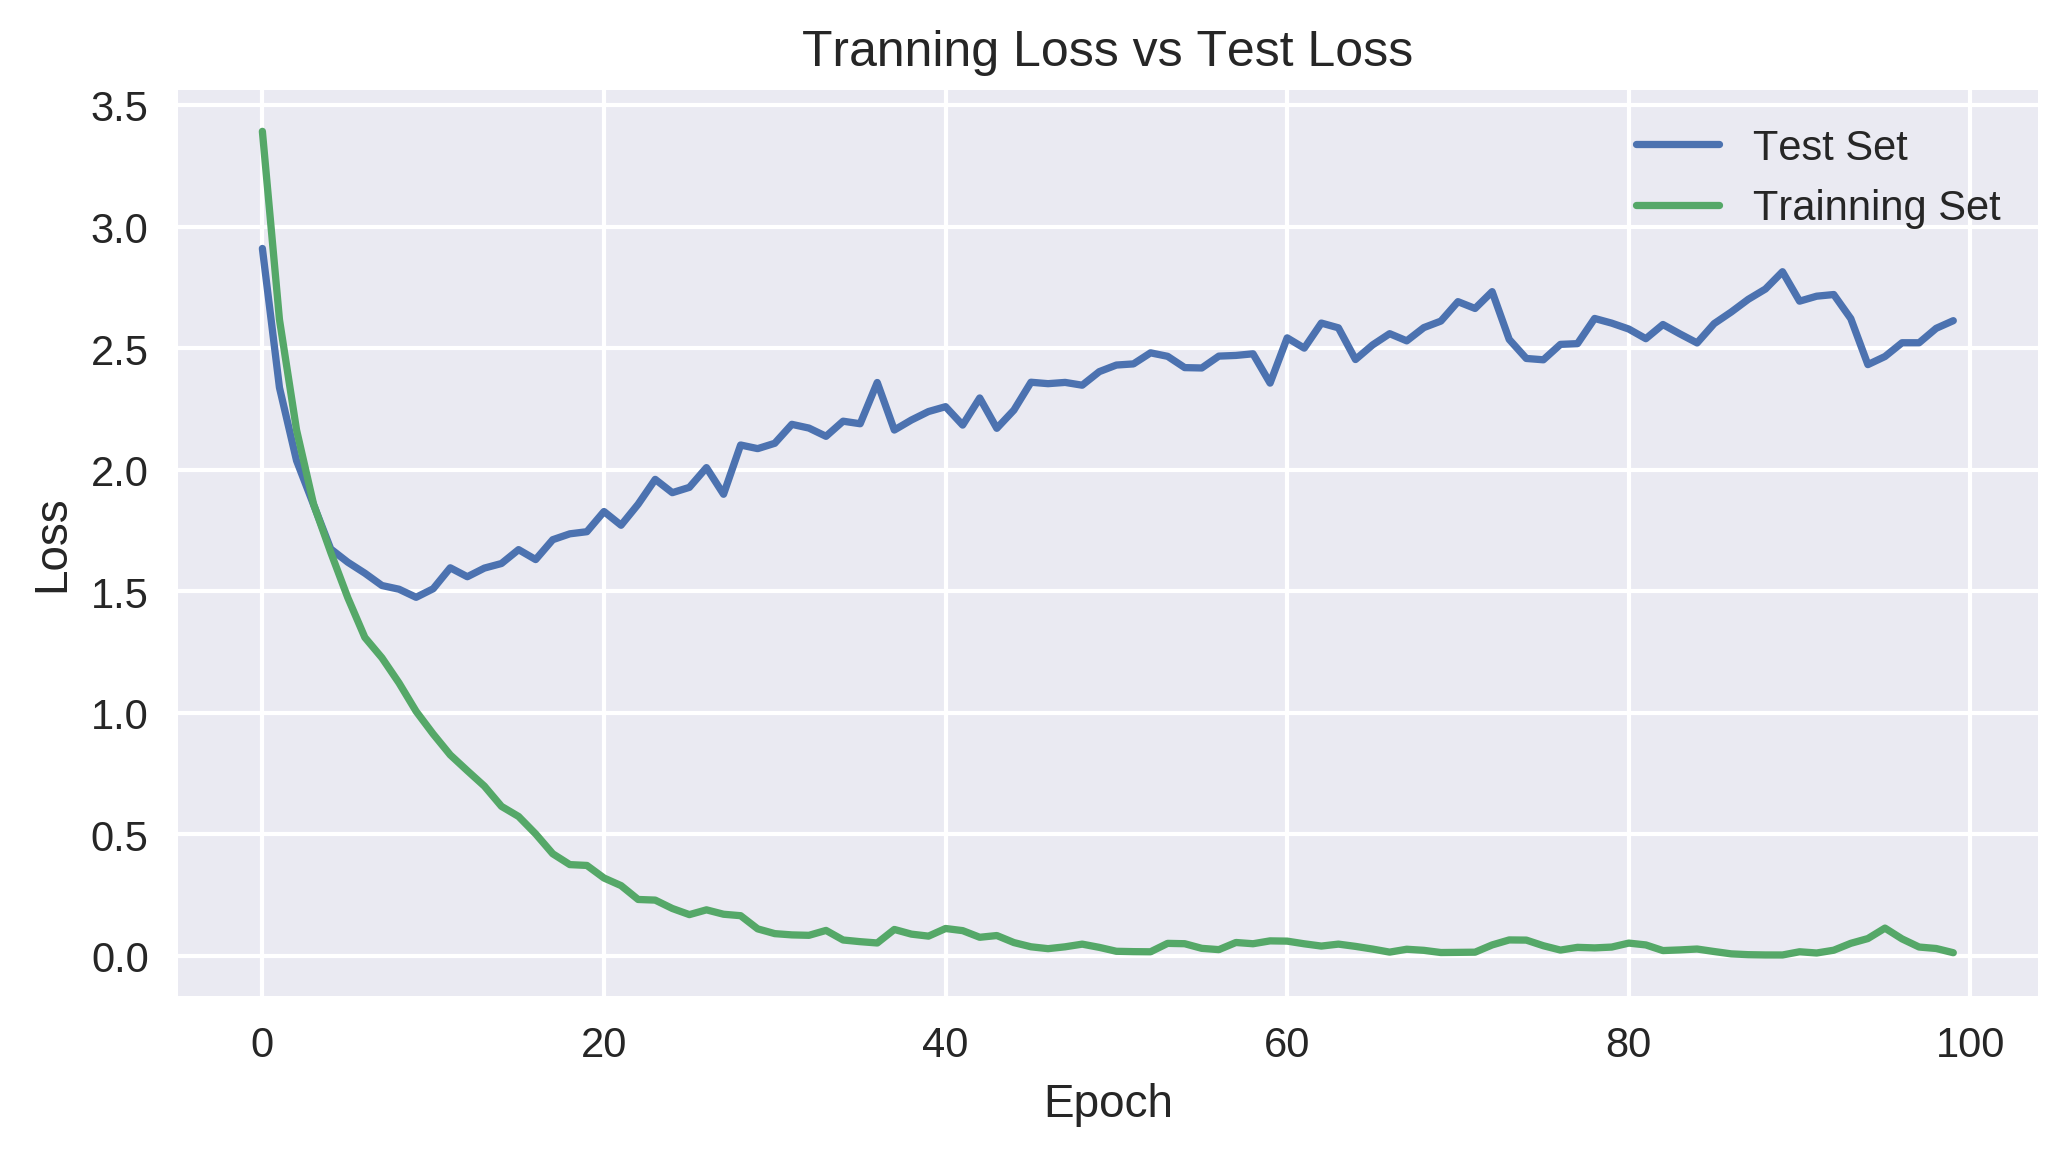

In [19]:
# plot metrics
plt.figure(figsize=(8, 4), dpi=300)
plt.title("Tranning Loss vs Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['val_loss'], label="Test Set")
plt.plot(history.history['loss'], label="Trainning Set")
plt.legend()
plt.show()


### Save History

In [0]:
import pickle
  
f = open('ServeNet/trainHistoryDictGlove200-1-BI-LTSM', 'wb')
pickle.dump(history.history, f)
f.close()
  

### Load History

In [0]:
f = open('ServeNet/trainHistoryDictGlove200-1-BI-LTSM', 'rb')
his = pickle.load(f)
f.close()

In [22]:
his['loss']

[3.392031338918419,
 2.618097387686249,
 2.163951592038568,
 1.8578270872898706,
 1.6606754227605018,
 1.4740655825640876,
 1.3104190245411982,
 1.226585073349556,
 1.1232012670409661,
 1.0066150488942094,
 0.913149195939585,
 0.8272143783467194,
 0.7622185538044912,
 0.6986588181774853,
 0.6155495556443105,
 0.5739865094940606,
 0.5022503654900757,
 0.4206595918667899,
 0.37600209385571215,
 0.37261203560984135,
 0.3208895256502294,
 0.28961843608063487,
 0.23263046220284325,
 0.22999332043010143,
 0.19560009848487417,
 0.17029116382893708,
 0.18996466403118747,
 0.17189277377413895,
 0.16591755257559193,
 0.11170596575356903,
 0.09209876940173498,
 0.08691288042865362,
 0.08514136599522865,
 0.10531441873405185,
 0.06593827139547229,
 0.059056703090689736,
 0.053690116110032056,
 0.10928184115599048,
 0.09003002976646245,
 0.08179568133080635,
 0.11319948822740526,
 0.10445667170038603,
 0.07709404010663666,
 0.08425254952040973,
 0.055353350839223915,
 0.037971511376565584,
 0.03024

### Model Save

In [0]:
model.save('ServeNet/Serve_Net_Glove200_1_BI_LTSM.h5') 

### Model Load

In [0]:
model = load_model('ServeNet/Serve_Net_Glove200_1_BI_LTSM.h5')

In [25]:
print("Training set:")
loss_train, mae_train, top5error_train = model.evaluate(X_train, Y_train)
print("Training accuracy = ", top5error_train)
print('Test set:')
loss_test, mae_test, top5error_test = model.evaluate(X_test, Y_test)
print("Training accuracy = ", top5error_test)

Training set:
8123/8123 [==============================] - 37s 5ms/step
Training accuracy =  1.0
Test set:
2061/2061 [==============================] - 9s 5ms/step
Training accuracy =  0.8554099952347471


In [0]:
# This code allows you to see the mislabelled examples
C = 50
# y_test_oh = np.eye(C)[Y_test.reshape(-1)]
# X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
predY_test = model.predict(X_test)

In [27]:
print(predY_test.shape)
print(Y_test.shape)

(2061, 50)
(2061, 50)


In [28]:
print(np.argmax(predY_test[0]))
print(np.argmax(Y_test[0]))

46
21


In [29]:
# Heatmap Data
non_onehot_pred_test = np.argmax(predY_test, axis=1)
non_onehot_Y_test = np.argmax(Y_test, axis=1)
categories = ['Financial', 'Project Management', 'Banking', 'Backend', 'Shipping', 'File Sharing', 'Email', 'Mapping', 'Domains', 'Social', 'Weather', 'Storage', 'Tools', 'Games', 'Events', 'Security', 'Analytics', 'Travel', 'Data', 'Reference', 'Office', 'Medical', 'Photos', 'Images', 'Education', 'Cloud', 'Chat', 'Application Development', 'Database', 'Messaging', 'News Services', 'Advertising', 'eCommerce', 'Transportation', 'Government', 'Other', 'Music', 'Sports', 'Internet of Things', 'Science', 'Telephony', 'Stocks', 'Media', 'Entertainment', 'Payments', 'Real Estate', 'Bitcoin', 'Search', 'Enterprise', 'Video', 'All']

print(non_onehot_pred_test.shape)
print(non_onehot_Y_test.shape)


(2061,)
(2061,)


In [0]:
# Heat Map

# cross = pd.crosstab(non_onehot_Y_test, non_onehot_pred_test.reshape(len(non_onehot_pred_test),), rownames=['Actual'], colnames=['Predicted'], margins=True)
cross = pd.crosstab(non_onehot_Y_test, non_onehot_pred_test, rownames=['Actual'], colnames=['Predicted'], margins=True)  

In [31]:
cross.index = categories
cross.index.name = "Actual"
cross.columns = categories
cross.columns.name = "Predicted"
cross.head()

Predicted,Financial,Project Management,Banking,Backend,Shipping,File Sharing,Email,Mapping,Domains,Social,...,Stocks,Media,Entertainment,Payments,Real Estate,Bitcoin,Search,Enterprise,Video,All
Actual,,,,,,,,,,,,,,,,,,,,,
Financial,7,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,16
Project Management,0,29,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,41
Banking,0,1,30,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,39
Backend,0,0,0,4,0,0,0,0,0,0,...,0,0,0,0,0,3,0,0,0,16
Shipping,0,1,1,1,11,0,0,0,0,0,...,1,1,0,0,0,0,1,0,0,28


In [32]:
sns.load_dataset("flights").head()

,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132
3,1949,April,129
4,1949,May,121


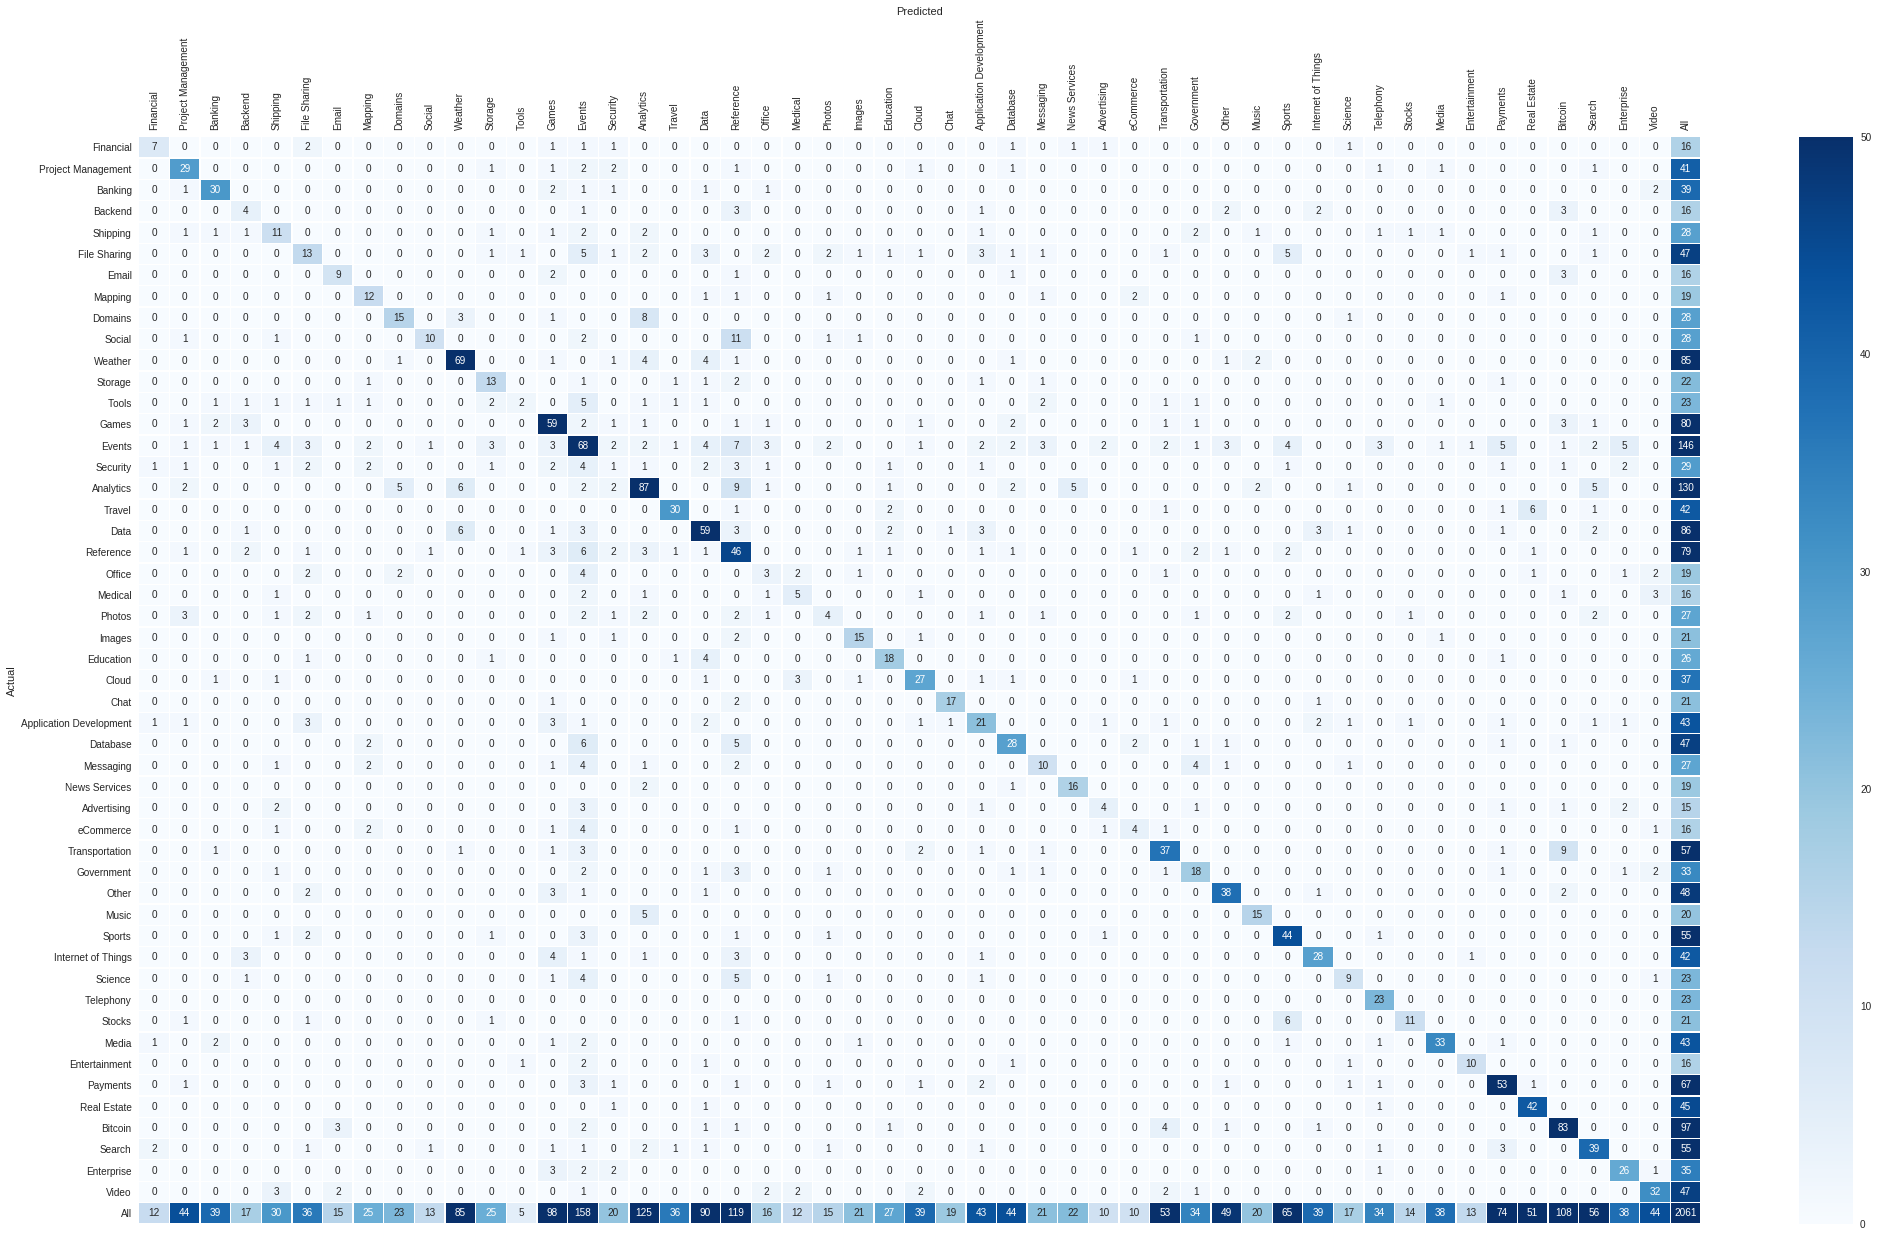

In [33]:
f, ax = plt.subplots(figsize=(35,20))

sns.heatmap(cross, annot=True, vmin=0, fmt="d", vmax=50, ax=ax, linewidths=.3, cmap=plt.cm.Blues)

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')


plt.yticks(rotation=0) 
plt.xticks(rotation=90) 

plt.savefig('ServeNet/heatmap.pdf', format='pdf', dpi=300)